# Clustering

### CA5 @ AI Course

*Full Name:* Kasra Kashani

*SID:* 810101490

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import fcluster, linkage
import re
from sentence_transformers import SentenceTransformer
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

f:\python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preprocess

In [2]:
df = pd.read_csv("dataset.csv")
orginal_df = df.copy()
df

,document
0,From: melabdel@cobra.cs.unm.edu (Mohammed Elab...
1,From: bc744@cleveland.Freenet.Edu (Mark Ira Ka...
2,From: lundby@rtsg.mot.com (Walter F. Lundby)\n...
3,From: ajs8@kimbark.uchicago.edu (adam jeremy s...
4,From: npm@netcom.com (Nancy P. Milligan)\nSubj...
...,...
3892,From: geb@cs.pitt.edu (Gordon Banks)\nSubject:...
3893,From: kirsch@staff.tc.umn.edu (Dave 'Almost Cu...
3894,Subject: POV file constructor for Unix/X11\nFr...
3895,From: narain@ih-nxt09.cso.uiuc.edu (Nizam Arai...


In [3]:
stop_words = stopwords.words("english")
stemmer = nltk.PorterStemmer()
lemmatizer = nltk.WordNetLemmatizer()

print(stop_words)
print(stemmer.stem("cars"), stemmer.stem("running"))
print(lemmatizer.lemmatize("babies"), stemmer.stem("spending"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [4]:
def delete_signwords(txt):
    new_text = txt
    repeated_words = ["From:", "Subject:", "Re:", "Organization:", "Lines:"]

    new_text = re.sub(r'[\n\r\t>,.?!{}()/-]', ' ', new_text)
    new_text = re.sub(r'\s+', ' ', new_text)
    for word in new_text.split():
      if (word in repeated_words) or (word[0].isnumeric()) or ('@' in word):
        new_text = new_text.replace(word, ' ')
    new_text = re.sub(r':', ' ', new_text)

    return new_text

df["document"] = df["document"].apply(delete_signwords)
df

,document
0,cs unm edu Mohammed Elabdellaoui Europ...
1,Freenet Edu Mark Ira Kaufman Israel does...
2,mot com Walter F Lundby Is MSG sensiti...
3,uchicago edu adam jeremy schorr Graphics...
4,com Nancy P Milligan Need advice with ...
...,...
3892,pitt edu Gordon Banks Eugenics Reply T...
3893,tc umn edu Dave 'Almost Cursed the Jays' K...
3894,POV file constructor for Unix X11 Craig ...
3895,nxt09 cso uiuc edu Nizam Arain Europe ...


In [5]:
def lemmatizing(txt):
    new_txt = []
    for word in txt.split():
        new_txt.append(lemmatizer.lemmatize(word))
    new_txt = ' '.join(new_txt)
    
    return new_txt

df["document"] = df["document"].apply(lemmatizing)
df

,document
0,c unm edu Mohammed Elabdellaoui Europe v Musli...
1,Freenet Edu Mark Ira Kaufman Israel doe not ki...
2,mot com Walter F Lundby Is MSG sensitivity sup...
3,uchicago edu adam jeremy schorr Graphics Neede...
4,com Nancy P Milligan Need advice with doctor p...
...,...
3892,pitt edu Gordon Banks Eugenics Reply To pitt e...
3893,tc umn edu Dave 'Almost Cursed the Jays' Kirsc...
3894,POV file constructor for Unix X11 Craig vuw ac...
3895,nxt09 cso uiuc edu Nizam Arain Europe v Muslim...


In [6]:
def stemming(txt):
    new_txt = []
    for word in txt.split():
        new_txt.append(stemmer.stem(word))
    new_txt = ' '.join(new_txt)
    
    return new_txt

stemmed_df = df["document"].apply(stemming)
stemmed_df

0       c unm edu moham elabdellaoui europ v muslim bo...
1       freenet edu mark ira kaufman israel doe not ki...
2       mot com walter f lundbi is msg sensit supersti...
3       uchicago edu adam jeremi schorr graphic need r...
4       com nanci p milligan need advic with doctor pa...
                              ...                        
3892    pitt edu gordon bank eugen repli to pitt edu g...
3893    tc umn edu dave 'almost curs the jays' kirsch ...
3894    pov file constructor for unix x11 craig vuw ac...
3895    nxt09 cso uiuc edu nizam arain europ v muslim ...
3896    "gabriel d underwood" edu pregnenc without sex...
Name: document, Length: 3897, dtype: object

In [7]:
def delete_stopwords(txt):
    new_txt = []
    for word in txt.split():
        if word.lower() not in stop_words:
            new_txt.append(word)
    new_txt = ' '.join(new_txt)
    
    return new_txt

df["document"] = df["document"].apply(delete_stopwords)
df

,document
0,c unm edu Mohammed Elabdellaoui Europe v Musli...
1,Freenet Edu Mark Ira Kaufman Israel doe kill r...
2,mot com Walter F Lundby MSG sensitivity supers...
3,uchicago edu adam jeremy schorr Graphics Neede...
4,com Nancy P Milligan Need advice doctor patien...
...,...
3892,pitt edu Gordon Banks Eugenics Reply pitt edu ...
3893,tc umn edu Dave 'Almost Cursed Jays' Kirsch Be...
3894,POV file constructor Unix X11 Craig vuw ac nz ...
3895,nxt09 cso uiuc edu Nizam Arain Europe v Muslim...


In [8]:
def lowercasing(txt):
    new_txt = txt.lower()

    return new_txt

df["document"] = df["document"].apply(lowercasing)
df

,document
0,c unm edu mohammed elabdellaoui europe v musli...
1,freenet edu mark ira kaufman israel doe kill r...
2,mot com walter f lundby msg sensitivity supers...
3,uchicago edu adam jeremy schorr graphics neede...
4,com nancy p milligan need advice doctor patien...
...,...
3892,pitt edu gordon banks eugenics reply pitt edu ...
3893,tc umn edu dave 'almost cursed jays' kirsch be...
3894,pov file constructor unix x11 craig vuw ac nz ...
3895,nxt09 cso uiuc edu nizam arain europe v muslim...


# Feature Extraction

In [9]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [10]:
def convert_embedding(txt):
    new_text = model.encode(txt)

    return new_text

df["embedding"] = df["document"].apply(convert_embedding)
df

,document,embedding
0,c unm edu mohammed elabdellaoui europe v musli...,"[0.01301131, 0.060525067, -0.05381363, -0.0185..."
1,freenet edu mark ira kaufman israel doe kill r...,"[-0.03750137, 0.0991188, 0.0073684207, 0.00032..."
2,mot com walter f lundby msg sensitivity supers...,"[-0.022528265, -0.061722483, 0.06261797, 0.008..."
3,uchicago edu adam jeremy schorr graphics neede...,"[-0.06407395, -0.015139348, 0.05027682, -0.069..."
4,com nancy p milligan need advice doctor patien...,"[-0.08287047, 0.004022218, 0.056858614, -0.042..."
...,...,...
3892,pitt edu gordon banks eugenics reply pitt edu ...,"[-0.10413396, 0.024299355, -0.010338932, 0.017..."
3893,tc umn edu dave 'almost cursed jays' kirsch be...,"[-0.042757306, 0.053229645, 0.06911641, -0.027..."
3894,pov file constructor unix x11 craig vuw ac nz ...,"[-0.045146264, 0.059884615, -0.12788492, -0.06..."
3895,nxt09 cso uiuc edu nizam arain europe v muslim...,"[-0.005492047, 0.002614849, -0.057051435, -0.0..."


### 1) K-Means Clustering

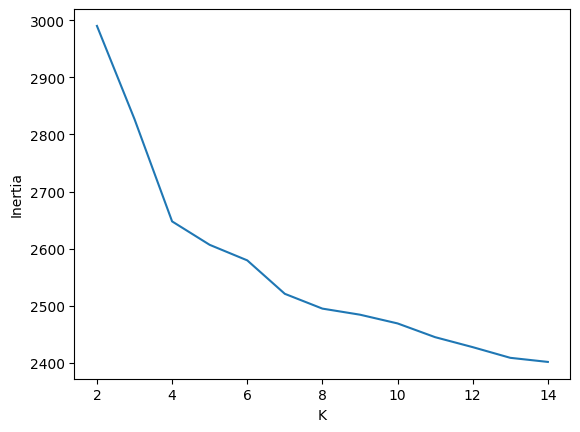

In [11]:
# elbow method

inertias = []
nums_of_clusters = range(2, 15)

for k in nums_of_clusters:
    kmeans = KMeans(n_clusters=k, random_state=20)
    kmeans.fit(df["embedding"].tolist())
    inertias.append(kmeans.inertia_)

plt.plot(nums_of_clusters, inertias)
plt.xlabel('K')
plt.ylabel("Inertia")
plt.show()

# Optimal K is 4

In [12]:
iters = [100, 200, 300, 400]
tols = [0.001, 0.01, 0.1]

for iter in iters:
    for tol in tols:
        kmeans = KMeans(n_clusters=4, random_state=20, max_iter=iter, tol=tol)
        df["K-Means_clustering"] = kmeans.fit_predict(df["embedding"].tolist())
        print(df["K-Means_clustering"].value_counts(), f"\nmax_iter={iter}, tol={tol}")
        print("Silhouette Score:", silhouette_score(df["embedding"].tolist(), df["K-Means_clustering"]), "\n\n")

# Use the best max_iter and tol
kmeans = KMeans(n_clusters=4, random_state=20, max_iter=200, tol=0.1)
df["K-Means_clustering"] = kmeans.fit_predict(df["embedding"].tolist())

K-Means_clustering
2    1064
1     982
3     962
0     889
Name: count, dtype: int64 
max_iter=100, tol=0.001
Silhouette Score: 0.10421723 


K-Means_clustering
2    1064
1     982
3     962
0     889
Name: count, dtype: int64 
max_iter=100, tol=0.01
Silhouette Score: 0.10421723 


K-Means_clustering
2    1063
1     981
3     964
0     889
Name: count, dtype: int64 
max_iter=100, tol=0.1
Silhouette Score: 0.10424378 


K-Means_clustering
2    1064
1     982
3     962
0     889
Name: count, dtype: int64 
max_iter=200, tol=0.001
Silhouette Score: 0.10421723 


K-Means_clustering
2    1064
1     982
3     962
0     889
Name: count, dtype: int64 
max_iter=200, tol=0.01
Silhouette Score: 0.10421723 


K-Means_clustering
2    1063
1     981
3     964
0     889
Name: count, dtype: int64 
max_iter=200, tol=0.1
Silhouette Score: 0.10424378 


K-Means_clustering
2    1064
1     982
3     962
0     889
Name: count, dtype: int64 
max_iter=300, tol=0.001
Silhouette Score: 0.10421723 


K-Means_clus

### 2) DBSCAN Clustering

In [13]:
epsilons = [0.1, 0.2, 0.3, 0.4]
min_samples = [2, 3, 4, 5]

for min_sample in min_samples:
    for epsilon in epsilons:
        dbscan = DBSCAN(eps=epsilon, min_samples=min_sample, leaf_size=50, metric="cosine")
        df["DBSCAN_clustering"] = dbscan.fit_predict(df["embedding"].tolist())
        print(df["DBSCAN_clustering"].value_counts(), f"\neps={epsilon}, min_samples={min_sample}")
        print("Silhouette Score:", silhouette_score(df["embedding"].tolist(), df["DBSCAN_clustering"]), "\n\n")

# Use the best eps and min_samples
dbscan = DBSCAN(eps=0.3, min_samples=3, leaf_size=50, metric="cosine")
df["DBSCAN_clustering"] = dbscan.fit_predict(df["embedding"].tolist())

DBSCAN_clustering
-1      3563
 13        7
 28        7
 16        4
 88        4
        ... 
 140       2
 141       2
 142       2
 143       2
 144       2
Name: count, Length: 146, dtype: int64 
eps=0.1, min_samples=2
Silhouette Score: -0.19518486 


DBSCAN_clustering
-1      2404
 6        96
 0        25
 41       22
 79       18
        ... 
 433       2
 432       2
 14        2
 13        2
 10        2
Name: count, Length: 452, dtype: int64 
eps=0.2, min_samples=2
Silhouette Score: -0.05629949 


DBSCAN_clustering
-1      1279
 0       658
 8       449
 1       111
 22       30
        ... 
 408       2
 407       2
 406       2
 405       2
 419       2
Name: count, Length: 421, dtype: int64 
eps=0.3, min_samples=2
Silhouette Score: -0.0067180516 


DBSCAN_clustering
 0      2857
-1       532
 24       22
 43       16
 22       13
        ... 
 167       2
 168       2
 169       2
 170       2
 171       2
Name: count, Length: 173, dtype: int64 
eps=0.4, min_samples=2
Sil

### 3) Hierarchical Clustering

In [14]:
criterions = ["inconsistent", "maxclust"]
depths = [2, 3, 4, 5, 6]

for criterion in criterions:
    for depth in depths:
        df["Hierarchical_clustering"] = fcluster(linkage(df["embedding"].tolist(), method="ward", metric="euclidean"), t=4, criterion=criterion, depth=depth)
        print(df["Hierarchical_clustering"].value_counts(), f"\ncriterion={criterion}, depth={depth}")
        if len(set(df["Hierarchical_clustering"])) > 1:
            print("Silhouette Score:", silhouette_score(df["embedding"].tolist(), df["Hierarchical_clustering"]), "\n\n")
        else:
            print(f"Only 1 cluster formed.\n")

# Use the best criterion and depth
df["Hierarchical_clustering"] = fcluster(linkage(df["embedding"].tolist(), method="ward", metric="euclidean"), t=4, criterion="maxclust", depth=4)

Hierarchical_clustering
1    3897
Name: count, dtype: int64 
criterion=inconsistent, depth=2
Only 1 cluster formed.

Hierarchical_clustering
1    3897
Name: count, dtype: int64 
criterion=inconsistent, depth=3
Only 1 cluster formed.

Hierarchical_clustering
1    3897
Name: count, dtype: int64 
criterion=inconsistent, depth=4
Only 1 cluster formed.

Hierarchical_clustering
1     955
7     879
12    832
6     596
8     196
9     155
3     126
2      41
11     40
10     33
5      24
4      20
Name: count, dtype: int64 
criterion=inconsistent, depth=5
Silhouette Score: 0.054218303 


Hierarchical_clustering
1     955
15    832
10    679
6     596
11    196
12    155
3     126
7      83
9      77
2      41
8      40
14     40
13     33
5      24
4      20
Name: count, dtype: int64 
criterion=inconsistent, depth=6
Silhouette Score: 0.051441792 


Hierarchical_clustering
4    1256
1     955
3     879
2     807
Name: count, dtype: int64 
criterion=maxclust, depth=2
Silhouette Score: 0.09754965

## Dimension Reduction

In [15]:
df

,document,embedding,K-Means_clustering,DBSCAN_clustering,Hierarchical_clustering
0,c unm edu mohammed elabdellaoui europe v musli...,"[0.01301131, 0.060525067, -0.05381363, -0.0185...",0,0,2
1,freenet edu mark ira kaufman israel doe kill r...,"[-0.03750137, 0.0991188, 0.0073684207, 0.00032...",0,0,2
2,mot com walter f lundby msg sensitivity supers...,"[-0.022528265, -0.061722483, 0.06261797, 0.008...",1,1,3
3,uchicago edu adam jeremy schorr graphics neede...,"[-0.06407395, -0.015139348, 0.05027682, -0.069...",2,-1,3
4,com nancy p milligan need advice doctor patien...,"[-0.08287047, 0.004022218, 0.056858614, -0.042...",1,-1,3
...,...,...,...,...,...
3892,pitt edu gordon banks eugenics reply pitt edu ...,"[-0.10413396, 0.024299355, -0.010338932, 0.017...",1,10,3
3893,tc umn edu dave 'almost cursed jays' kirsch be...,"[-0.042757306, 0.053229645, 0.06911641, -0.027...",3,6,1
3894,pov file constructor unix x11 craig vuw ac nz ...,"[-0.045146264, 0.059884615, -0.12788492, -0.06...",2,-1,4
3895,nxt09 cso uiuc edu nizam arain europe v muslim...,"[-0.005492047, 0.002614849, -0.057051435, -0.0...",0,0,2


In [16]:
pca = PCA(n_components=2)
reduced_df = pca.fit_transform(df["embedding"].tolist())

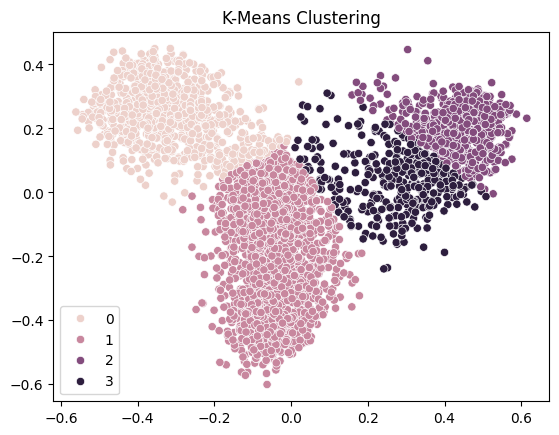

In [17]:
plt.figure()
sns.scatterplot(x=reduced_df[:, 0], y=reduced_df[:, 1], hue=kmeans.fit_predict(reduced_df), legend="full")
plt.title("K-Means Clustering")
plt.show()

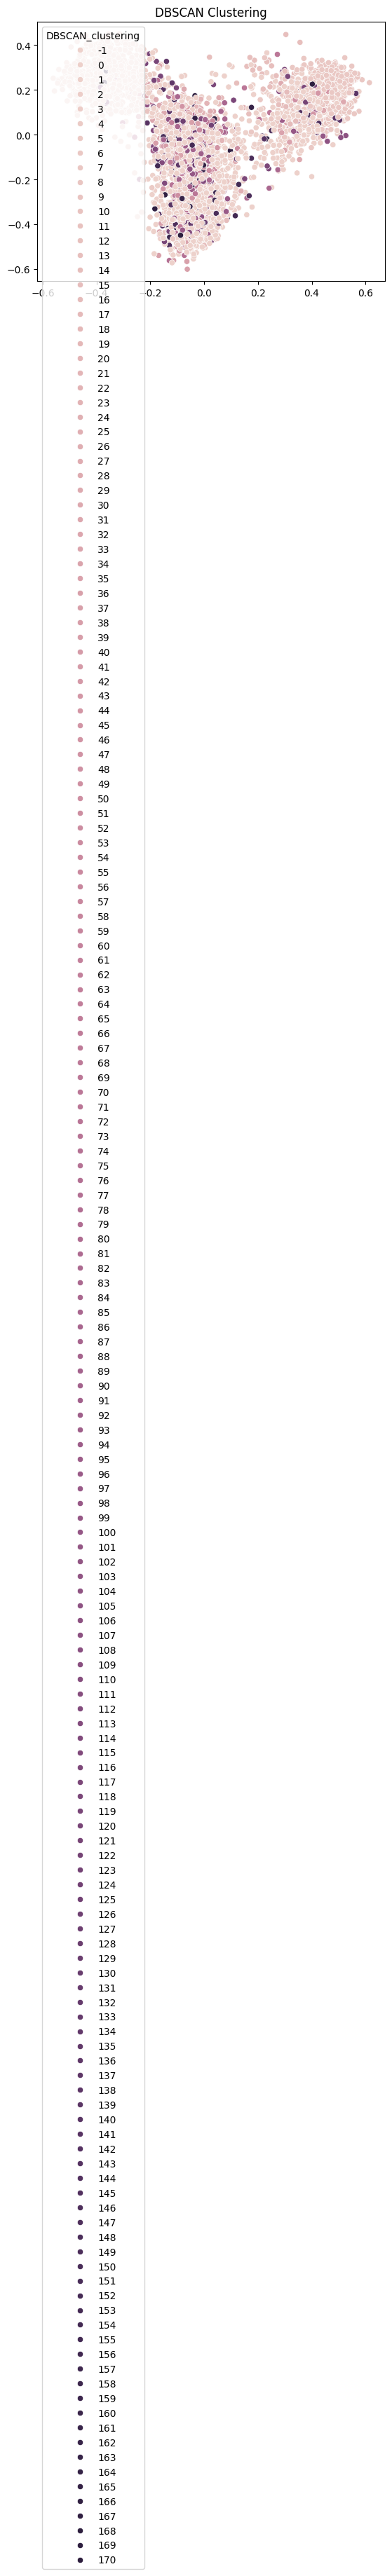

In [18]:
plt.figure()
sns.scatterplot(x=reduced_df[:, 0], y=reduced_df[:, 1], hue=df["DBSCAN_clustering"], legend="full")
plt.title("DBSCAN Clustering")
plt.show()

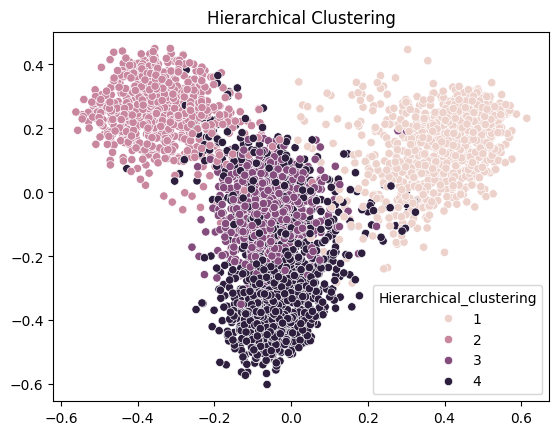

In [19]:
plt.figure()
sns.scatterplot(x=reduced_df[:, 0], y=reduced_df[:, 1], hue=df["Hierarchical_clustering"], legend="full")
plt.title("Hierarchical Clustering")
plt.show()

## Analysis

In [20]:
print("K-Means Silhouette Score: ", silhouette_score(reduced_df, df["K-Means_clustering"]))
print("DBSCAN Silhouette Score: ", silhouette_score(reduced_df, df["DBSCAN_clustering"]))
print("Hierarchical Silhouette Score: ", silhouette_score(reduced_df, df["Hierarchical_clustering"]))

# K-Means has the highest score

K-Means Silhouette Score:  0.47522180752131005
DBSCAN Silhouette Score:  -0.5927740405414702
Hierarchical Silhouette Score:  0.39453516996540244


In [21]:
print(df.loc[df["K-Means_clustering"] == 0]["document"], "\n\n")

print(orginal_df.loc[0, "document"])
print(orginal_df.loc[1, "document"])
print(orginal_df.loc[5, "document"])

# Politics

0       c unm edu mohammed elabdellaoui europe v musli...
1       freenet edu mark ira kaufman israel doe kill r...
5       c du edu mike silverman clinton's view jerusal...
6       com shai guday basil opinion water brain think...
14      uucp serdar argic muslim woman child openly ma...
                              ...                        
3879    oac uci edu tim clock peace talks resume nntp ...
3884    many israeli soldier doe take kill yr old chil...
3887    uucp serdar argic 'justice' victim armenian ba...
3889    uucp serdar argic quaintly charming habit arme...
3895    nxt09 cso uiuc edu nizam arain europe v muslim...
Name: document, Length: 889, dtype: object 


From: melabdel@cobra.cs.unm.edu (Mohammed Elabdellaoui)
Subject: Re: Europe vs. Muslim Bosnians
Organization: Computer Science Department, University of New Mexico
Lines: 34

In article <C6x81M.EJF@news.cis.umn.edu> prabhak@giga.cs.umn.edu (Satya Prabhakar) writes:
>(mohamed.s.sadek) writes:
>>
>>I like what Mr. Jo

In [22]:
print(df.loc[df["DBSCAN_clustering"] == 1]["document"], "\n\n")

print(orginal_df.loc[2, "document"])
print(orginal_df.loc[40, "document"])
print(orginal_df.loc[62, "document"])

# Food

2       mot com walter f lundby msg sensitivity supers...
40      carleton ca opirg msg sensitivity superstition...
62      cwru edu elisabeth davidson candida yeast bloo...
105     usu edu msg sensitivity superstition utah stat...
156     jpl nasa gov julie kangas msg sensitivity supe...
                              ...                        
3771    bih harvard edu david rind good grief wa candi...
3782    com steve dyer msg sensitivity superstition p ...
3789    ocom okstate edu candida yeast bloom fact fict...
3882    hp com chris best msg sensitivity superstition...
3888    lonestar org steve giammarco msg sensitivity s...
Name: document, Length: 111, dtype: object 


From: lundby@rtsg.mot.com (Walter F. Lundby)
Subject: Re: Is MSG sensitivity superstition?
Nntp-Posting-Host: accord2
Organization: Motorola Inc., Cellular Infrastructure Group
Lines: 48


>>Is there such a thing as MSG (monosodium glutamate) sensitivity?
>>Superstition. Anybody here have experience to the contrary

In [23]:
print(df.loc[df["Hierarchical_clustering"] == 1]["document"], "\n\n")

print(orginal_df.loc[11, "document"])
print(orginal_df.loc[12, "document"])
print(orginal_df.loc[13, "document"])

# Sports

11      edu kevin mundstock predictions reply oswego e...
12      c laurentian ca roger maynard jack morris dept...
13      edu doe pitcher get save buena vista college s...
19      edu michael lurie liberalizer pleasant yankee ...
23      berkeley edu joseph hernandez mlb scores corre...
                              ...                        
3871    csd harris com tom horsley *real* way speed ba...
3874    atmos uiuc edu harold_brooks rbi risp slg bill...
3890    tju edu ken johnston professional sports fm ra...
3891    cv hp com paul andresen braves pitching update...
3893    tc umn edu dave 'almost cursed jays' kirsch be...
Name: document, Length: 955, dtype: object 


From: iacs3650@Oswego.EDU (Kevin Mundstock)
Subject: My Predictions For 1993
Reply-To: iacs3650@oswego.Oswego.EDU (Kevin Mundstock)
Organization: Instructional Computing Center, SUNY at Oswego, Oswego, NY
Lines: 62

Since everyone else seems to be running wild with predictions, I've
decided to add my own fuel to th